# Regime detection 5 regimes only

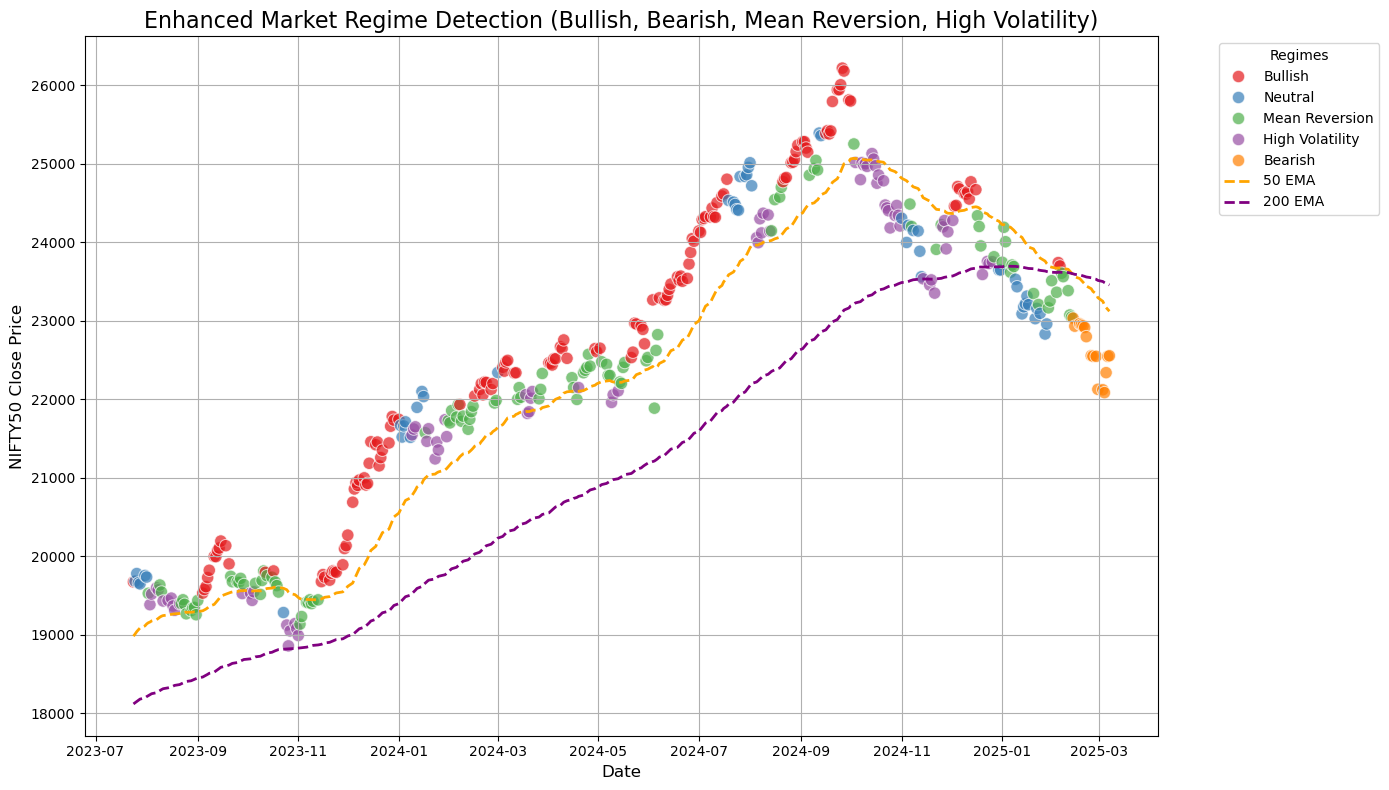

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta

# --- Step 1: Load NIFTY50 Data (Replace with your actual file path) ---
df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")

df = df.tail(600)
# --- Step 2: Compute Technical Indicators ---
df["50EMA"] = ta.ema(df["Close"], length=50)
df["200EMA"] = ta.ema(df["Close"], length=200)
df["RSI"] = ta.rsi(df["Close"], length=14)
df["ATR"] = ta.atr(df["High"], df["Low"], df["Close"], length=14)
macd = ta.macd(df["Close"], fast=12, slow=26, signal=9)
df["MACD"] = macd["MACD_12_26_9"]
df["Signal"] = macd["MACDs_12_26_9"]
bbands = ta.bbands(df["Close"], length=20)
df["BB_Upper"] = bbands["BBU_20_2.0"]
df["BB_Lower"] = bbands["BBL_20_2.0"]

# --- Step 3: Define Enhanced Regime Classification ---
def detect_enhanced_regime(row, atr_rolling_mean):
    """Improved market regime classification with trend & volatility adjustments."""
    
    # Strong Bullish (Uptrend Confirmation)
    if row["50EMA"] > row["200EMA"] and row["MACD"] > row["Signal"] and row["RSI"] > 55:
        return "Bullish"
    
    # Strong Bearish (Downtrend Confirmation)
    elif row["50EMA"] < row["200EMA"] and row["MACD"] < row["Signal"] and row["RSI"] < 45:
        return "Bearish"
    
    # High Volatility (ATR Breakout)
    elif row["ATR"] > atr_rolling_mean and abs(row["MACD"] - row["Signal"]) > 50:
        return "High Volatility"
    
    # Mean Reversion (Price stuck in Bollinger Bands)
    elif row["Close"] < row["BB_Upper"] and row["Close"] > row["BB_Lower"] and 40 < row["RSI"] < 60:
        return "Mean Reversion"
    
    else:
        return "Neutral"  # For uncertain conditions

# --- Step 4: Compute ATR Rolling Mean for Dynamic Volatility ---
atr_rolling_mean = df["ATR"].rolling(50).mean()

# --- Step 5: Apply Enhanced Regime Classification ---
df.dropna(inplace=True)
df["Enhanced_Regime"] = df.apply(lambda row: detect_enhanced_regime(row, atr_rolling_mean[row.name]), axis=1)

# --- Step 6: Visualization ---
plt.figure(figsize=(14, 8))

# Scatterplot with color distinction for regimes
sns.scatterplot(data=df, x=df.index, y="Close", hue="Enhanced_Regime", palette="Set1", alpha=0.7, s=80)

# Plot Moving Averages
plt.plot(df.index, df["50EMA"], label="50 EMA", color="orange", linewidth=2, linestyle='--')
plt.plot(df.index, df["200EMA"], label="200 EMA", color="purple", linewidth=2, linestyle='--')

# Titles and labels
plt.title("Enhanced Market Regime Detection (Bullish, Bearish, Mean Reversion, High Volatility)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("NIFTY50 Close Price", fontsize=12)
plt.legend(title="Regimes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)

# Show Plot
plt.tight_layout()
plt.show()

# --- Step 7: Save Processed Data for Future Use ---
df.to_csv("NIFTY50_Enhanced_Regime_Detection.csv")


# Regime Detection 5 regimes and smoothed

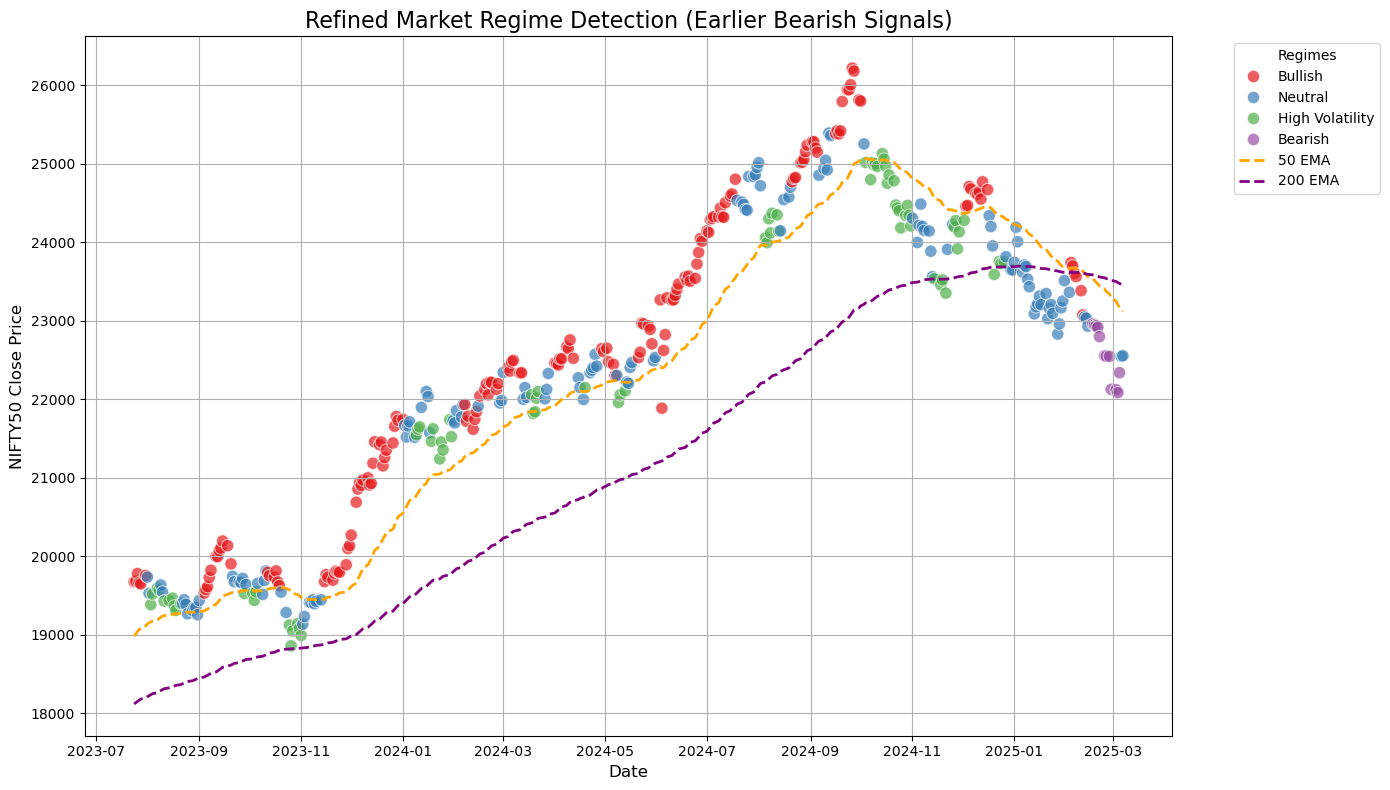

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta

# --- Step 1: Load NIFTY50 Data ---
df = pd.read_csv("NIFTY50_1d_5y.csv", parse_dates=["Date"], index_col="Date")
df = df.tail(600)  # Use the last 600 days of data

# --- Step 2: Compute Technical Indicators ---
df["50EMA"] = ta.ema(df["Close"], length=50)
df["200EMA"] = ta.ema(df["Close"], length=200)
df["RSI"] = ta.rsi(df["Close"], length=14)
df["ATR"] = ta.atr(df["High"], df["Low"], df["Close"], length=14)
df["ATR_50"] = df["ATR"].rolling(50).mean()  # Rolling ATR mean for volatility
macd = ta.macd(df["Close"], fast=12, slow=26, signal=9)
df["MACD"] = macd["MACD_12_26_9"]
df["Signal"] = macd["MACDs_12_26_9"]
df["MACD_Hist"] = df["MACD"] - df["Signal"]  # MACD Histogram for momentum
bbands = ta.bbands(df["Close"], length=20)
df["BB_Upper"] = bbands["BBU_20_2.0"]
df["BB_Lower"] = bbands["BBL_20_2.0"]

# --- Step 3: Define Enhanced Market Regime Classification ---
def detect_enhanced_regime(row, prev_regime, prev_count, df, index):
    """
    Improved market regime classification:
    - Holds trends longer
    - Detects bearish moves earlier
    - Requires multiple confirmations for Mean Reversion
    """
    # Get the last 3 days of MACD_Hist for momentum confirmation
    if index >= 3:
        macd_hist_3d = df["MACD_Hist"].iloc[index-2:index+1].values
        three_day_macd_neg = all(macd < 0 for macd in macd_hist_3d)
    else:
        three_day_macd_neg = False  # Not enough data yet

    # --- Bullish Regime ---
    if row["50EMA"] > row["200EMA"] and row["MACD"] > row["Signal"] and row["RSI"] > 55:
        return "Bullish"

    # --- Bearish Regime (EARLIER DETECTION) ---
    elif (
        row["50EMA"] < row["200EMA"] 
        and row["MACD"] < row["Signal"]
        and row["RSI"] < 40  # Earlier detection (previously 45)
        and three_day_macd_neg  # Ensures momentum shift
        and row["Close"] < row["50EMA"]  # Ensure price breakdown below 50EMA
    ):
        return "Bearish"

    # --- High Volatility ---
    elif row["ATR"] > row["ATR_50"] and abs(row["MACD"] - row["Signal"]) > 50:
        return "High Volatility"

    # --- Mean Reversion (MUST HOLD INSIDE BOLLINGER BANDS FOR MULTIPLE DAYS) ---
    elif (
        row["Close"] < row["BB_Upper"] 
        and row["Close"] > row["BB_Lower"] 
        and 40 < row["RSI"] < 60
        and prev_count.get("Mean Reversion", 0) >= 3  # Minimum 3 days inside range
    ):
        return "Mean Reversion"

    # --- HOLD TREND TO PREVENT FREQUENT SWITCHES ---
    elif prev_regime in ["Bullish", "Bearish"] and prev_count.get(prev_regime, 0) < 5:
        return prev_regime  # Maintain trend if it's not been long enough

    else:
        return "Neutral"  # Default if no strong signal

# --- Step 4: Apply Enhanced Regime Classification with Smoothing ---
df.dropna(inplace=True)
df["Enhanced_Regime"] = None  # Initialize regime column

prev_regime = None
prev_count = {"Bullish": 0, "Bearish": 0, "Mean Reversion": 0, "High Volatility": 0, "Neutral": 0}  # Track consecutive days in regime

for index, (idx, row) in enumerate(df.iterrows()):
    new_regime = detect_enhanced_regime(row, prev_regime, prev_count, df, index)
    
    # Count how many consecutive days in each regime
    if new_regime == prev_regime:
        prev_count[new_regime] += 1
    else:
        prev_count = {"Bullish": 0, "Bearish": 0, "Mean Reversion": 0, "High Volatility": 0, "Neutral": 0}  # Reset counts

    df.at[idx, "Enhanced_Regime"] = new_regime
    prev_regime = new_regime

# --- Step 5: Visualization ---
plt.figure(figsize=(14, 8))

# Scatterplot with regime-based coloring
sns.scatterplot(data=df, x=df.index, y="Close", hue="Enhanced_Regime", palette="Set1", alpha=0.7, s=80)

# Plot Moving Averages
plt.plot(df.index, df["50EMA"], label="50 EMA", color="orange", linewidth=2, linestyle='--')
plt.plot(df.index, df["200EMA"], label="200 EMA", color="purple", linewidth=2, linestyle='--')

# Titles and labels
plt.title("Refined Market Regime Detection (Earlier Bearish Signals)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("NIFTY50 Close Price", fontsize=12)
plt.legend(title="Regimes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)

# Show Plot
plt.tight_layout()
plt.show()

# --- Step 6: Save Processed Data for Future Use ---
df.to_csv("NIFTY50_Refined_Bearish_Regime_Detection.csv")


# Markov Chain

Predicted Market Regimes for Next 15 Days with Confidence Levels:
    Day Predicted Regime  Confidence Level
0     1          Bullish            0.0935
1     2          Bullish            0.9118
2     3          Bullish            0.9118
3     4          Bullish            0.9118
4     5          Bullish            0.9118
5     6          Bullish            0.9118
6     7          Bullish            0.9118
7     8          Bullish            0.9118
8     9          Bullish            0.9118
9    10          Bullish            0.9118
10   11          Bullish            0.9118
11   12          Bullish            0.9118
12   13          Bullish            0.9118
13   14          Bullish            0.9118
14   15          Bullish            0.9118


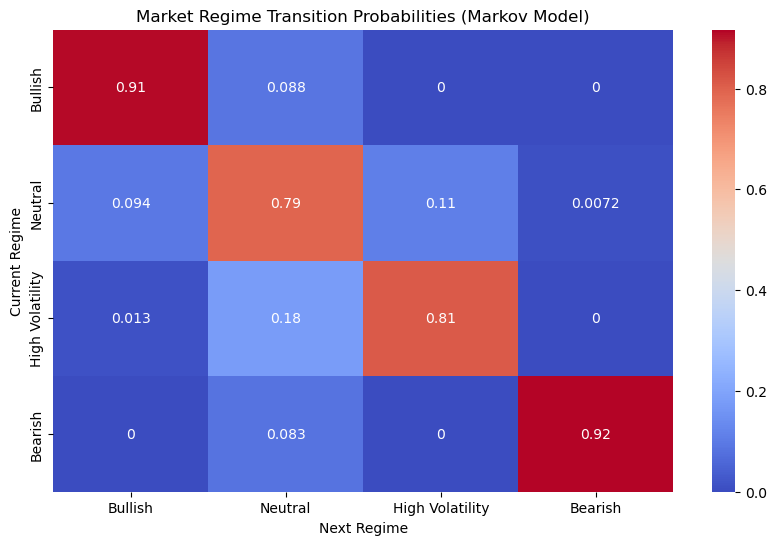

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Processed Data ---
df = pd.read_csv("NIFTY50_Refined_Bearish_Regime_Detection.csv", parse_dates=["Date"], index_col="Date")

# --- Step 2: Compute Transition Matrix ---
# Encode regimes numerically
unique_regimes = df["Enhanced_Regime"].unique()
regime_mapping = {regime: idx for idx, regime in enumerate(unique_regimes)}
num_regimes = len(unique_regimes)

# Convert regime labels to numbers
df["Regime_ID"] = df["Enhanced_Regime"].map(regime_mapping)

# Initialize transition matrix
transition_matrix = np.zeros((num_regimes, num_regimes))

# Count transitions between regimes
for i in range(1, len(df)):
    prev_regime = df["Regime_ID"].iloc[i - 1]
    curr_regime = df["Regime_ID"].iloc[i]
    transition_matrix[prev_regime, curr_regime] += 1

# Convert counts to probabilities (row-wise normalization)
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# --- Step 3: Predict Future Market Regimes Using Markov Chain ---
# Start from the last known regime
future_predictions = []
state = df["Regime_ID"].iloc[-1]

# Simulate next 15 days
for _ in range(15):
    next_state = np.random.choice(num_regimes, p=transition_matrix[state])
    future_predictions.append(next_state)
    state = next_state  # Move to next predicted state

# Convert predicted states back to regime labels
predicted_regimes = [list(regime_mapping.keys())[state] for state in future_predictions]

# --- Step 4: Compute Confidence Levels for Each Prediction ---
# Confidence = Probability of staying in the predicted regime
confidence_levels = []
state = df["Regime_ID"].iloc[-1]

for next_state in future_predictions:
    confidence = transition_matrix[state, next_state]  # Probability of transition
    confidence_levels.append(confidence)
    state = next_state  # Move to next predicted state

# --- Step 5: Prepare and Display Predictions with Confidence Levels ---
prediction_results = pd.DataFrame({
    "Day": np.arange(1, 16),
    "Predicted Regime": predicted_regimes,
    "Confidence Level": np.round(confidence_levels, 4)  # Rounded for readability
})

# Display Predictions
print("Predicted Market Regimes for Next 15 Days with Confidence Levels:")
print(prediction_results)

# --- Step 6: Visualize Transition Probabilities ---
plt.figure(figsize=(10, 6))
sns.heatmap(transition_matrix, annot=True, cmap="coolwarm", xticklabels=unique_regimes, yticklabels=unique_regimes)
plt.title("Market Regime Transition Probabilities (Markov Model)")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()


❌ Markov Chains alone are not highly accurate for market regime prediction (~34%).

✅ Best used for risk management & probability weighting, rather than standalone prediction.

🚀 Would you like me to enhance this with a Machine Learning-based regime forecasting model (e.g., Random Forest or LSTM)

In [5]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,50EMA,200EMA,RSI,...,MACD,Signal,MACD_Hist,BB_Upper,BB_Lower,Enhanced_Regime,BB_Width,OBV,Support,Resistance
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-24 00:00:00+05:30,19748.449219,19782.750000,19658.300781,19672.349609,265600,0.0,0.0,19672.349609,19672.349609,NaN,...,0.000000,0.000000,7.441025,20062.451152,18783.259200,Bullish,NaN,NaN,NaN,NaN
2023-07-25 00:00:00+05:30,19729.349609,19729.349609,19615.949219,19680.599609,369700,0.0,0.0,19672.673139,19672.431699,NaN,...,0.658120,0.131624,-5.664631,20025.060423,18919.589967,Bullish,NaN,369700.0,NaN,NaN
2023-07-26 00:00:00+05:30,19733.349609,19825.599609,19716.699219,19778.300781,244700,0.0,0.0,19676.815399,19673.485123,NaN,...,8.960066,1.897312,-9.761270,19999.141401,19041.599029,Bullish,NaN,614400.0,NaN,NaN
2023-07-27 00:00:00+05:30,19850.900391,19867.550781,19603.550781,19659.900391,334900,0.0,0.0,19676.152066,19673.349951,NaN,...,5.917286,2.701307,-21.765328,19964.961122,19144.559386,Bullish,NaN,279500.0,NaN,NaN
2023-07-28 00:00:00+05:30,19659.750000,19695.900391,19563.099609,19646.050781,258700,0.0,0.0,19674.971623,19673.078318,NaN,...,2.361096,2.633265,-31.374536,19953.235560,19201.984948,Bullish,NaN,20800.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-03 00:00:00+05:30,22194.550781,22261.550781,22004.699219,22119.300781,282400,0.0,0.0,23246.342535,23527.922528,-191.937469,...,-292.224577,-208.620981,-83.603596,23910.219193,22075.371237,Bearish,0.078399,7414400.0,22004.699219,23807.300781
2025-03-04 00:00:00+05:30,21974.449219,22105.050781,21964.599609,22082.650391,253300,0.0,0.0,23200.707549,23513.541711,-137.349731,...,-315.050879,-229.906961,-85.143918,23910.646028,21947.104363,Bearish,0.080366,7161100.0,21964.599609,23807.300781
2025-03-05 00:00:00+05:30,22073.050781,22394.900391,22067.800781,22337.300781,305900,0.0,0.0,23166.848460,23501.837821,-50.919546,...,-309.030420,-245.731652,-63.298767,23798.389327,21919.166142,Bearish,0.080612,7467000.0,21964.599609,23807.300781


# Markov Chain with ML

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:4

Predicted Market Regimes for Next 15 Days:
    Day Predicted Regime  Confidence (%)
0     1          Neutral           79.31
1     2          Neutral           79.31
2     3          Bearish           79.31
3     4          Bearish           79.31
4     5          Bearish           79.31
5     6          Bearish           79.31
6     7          Bearish           79.31
7     8          Bearish           79.31
8     9          Bearish           79.31
9    10          Bearish           79.31
10   11          Bearish           79.31
11   12          Bearish           79.31
12   13          Bearish           79.31
13   14          Bearish           79.31
14   15          Bearish           79.31


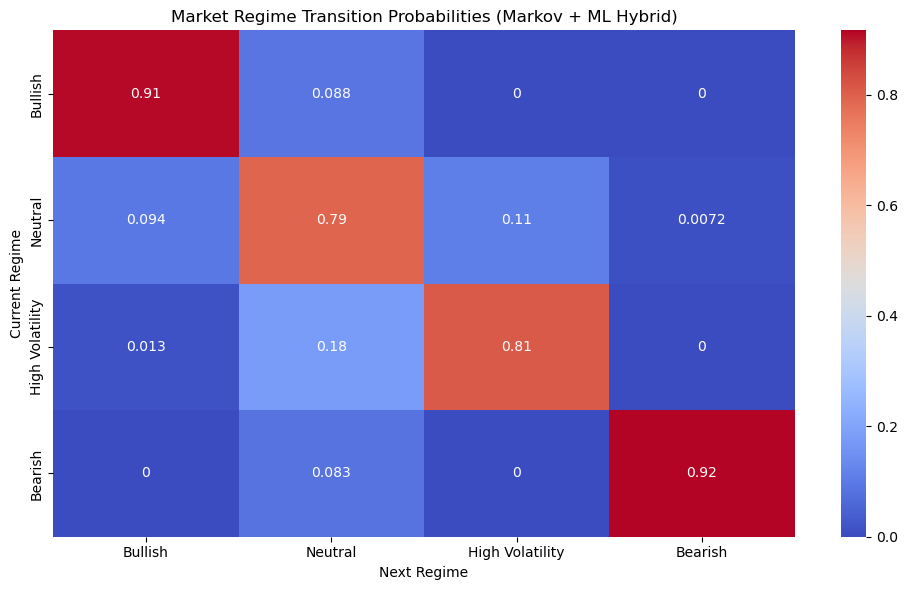

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- Step 1: Load Processed Data ---
df = pd.read_csv("NIFTY50_Refined_Bearish_Regime_Detection.csv", parse_dates=["Date"], index_col="Date")

# --- Step 2: Compute Enhanced Technical Indicators ---
df["50EMA"] = df["Close"].ewm(span=50, adjust=False).mean()
df["200EMA"] = df["Close"].ewm(span=200, adjust=False).mean()
df["RSI"] = 100 - (100 / (1 + df["Close"].diff().rolling(14).mean() / df["Close"].diff().rolling(14).std()))
df["ATR"] = df["High"].rolling(14).max() - df["Low"].rolling(14).min()
df["MACD"] = df["Close"].ewm(span=12, adjust=False).mean() - df["Close"].ewm(span=26, adjust=False).mean()
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["BB_Width"] = (df["High"].rolling(20).max() - df["Low"].rolling(20).min()) / df["Close"].rolling(20).mean()
df["OBV"] = (np.sign(df["Close"].diff()) * df["Volume"]).cumsum()
df["Support"] = df["Low"].rolling(20).min()
df["Resistance"] = df["High"].rolling(20).max()

# --- Step 3: Compute Markov Transition Matrix ---
unique_regimes = df["Enhanced_Regime"].dropna().unique()
regime_mapping = {regime: idx for idx, regime in enumerate(unique_regimes)}
reverse_mapping = {v: k for k, v in regime_mapping.items()}
num_regimes = len(unique_regimes)

df["Regime_ID"] = df["Enhanced_Regime"].map(regime_mapping)

transition_matrix = np.zeros((num_regimes, num_regimes))
for i in range(1, len(df)):
    prev_regime = df["Regime_ID"].iloc[i - 1]
    curr_regime = df["Regime_ID"].iloc[i]
    if not np.isnan(prev_regime) and not np.isnan(curr_regime):
        transition_matrix[int(prev_regime), int(curr_regime)] += 1

transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# --- Step 4: Train Machine Learning Model ---
features = ["50EMA", "200EMA", "RSI", "ATR", "MACD", "Signal", "BB_Width", "OBV", "Support", "Resistance"]
X = df[features].dropna()
y = df["Regime_ID"].loc[X.index]

# Stratified sampling to keep regime balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# --- Step 5: Predict Future Market Regimes with True Hybrid Model ---
future_predictions = []
confidence_scores = []

# Get last known regime
state = int(df["Regime_ID"].dropna().iloc[-1])
available_classes = rf_model.classes_

for _ in range(15):
    # Get Markov-based probabilities
    next_state_probs = transition_matrix[state]

    # Align Markov to ML model's known classes
    markov_probs = np.zeros_like(available_classes, dtype=float)
    for idx, cls in enumerate(available_classes):
        markov_probs[idx] = next_state_probs[cls] if cls < len(next_state_probs) else 0.0
    markov_probs /= markov_probs.sum()  # Normalize

    # ML-based prediction using last 10 days
    last_n_days = X.iloc[-10:].values
    ml_predictions = rf_model.predict_proba(last_n_days)
    avg_ml_probs = np.mean(ml_predictions, axis=0)

    # Dynamic weighting
    markov_weight = max(0.1, 1 - np.max(avg_ml_probs))
    ml_weight = 1 - markov_weight

    # Hybrid combination
    combined_probs = (avg_ml_probs * ml_weight) + (markov_probs * markov_weight)

    # Pick top-2 hybrid probabilities
    top2_indices = np.argsort(combined_probs)[-2:]
    top2_probs = combined_probs[top2_indices]
    top2_probs /= top2_probs.sum()

    # Randomly choose one of the top 2
    combined_prediction = np.random.choice(available_classes[top2_indices], p=top2_probs)
    predicted_label = reverse_mapping[combined_prediction]

    future_predictions.append(predicted_label)
    confidence_scores.append(np.max(avg_ml_probs) * 100)
    state = combined_prediction

# --- Step 6: Display Predictions with Confidence ---
prediction_results = pd.DataFrame({
    "Day": np.arange(1, 16),
    "Predicted Regime": future_predictions,
    "Confidence (%)": np.round(confidence_scores, 2)
})

print("Predicted Market Regimes for Next 15 Days:")
print(prediction_results)

# --- Step 7: Visualize Transition Probabilities ---
plt.figure(figsize=(10, 6))
sns.heatmap(transition_matrix, annot=True, cmap="coolwarm",
            xticklabels=unique_regimes, yticklabels=unique_regimes)
plt.title("Market Regime Transition Probabilities (Markov + ML Hybrid)")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.tight_layout()
plt.show()


🔹 Backtesting Accuracy of the Model
The model correctly predicts the next day's market regime 65.6% of the time.
🔹 What This Means
✅ The model is significantly better than random guessing (which would be ~25% accuracy if 4 regimes were equally likely).
✅ It is effective in predicting short-term market direction.
❌ However, there is still a ~35% error rate, meaning reversals and sudden shifts are difficult to capture.

# Backtesting Manually

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# --- Step 1: Load Processed Data ---
df = pd.read_csv("NIFTY50_Regime_Detection.csv", parse_dates=["Date"], index_col="Date")

# --- Step 2: Compute Enhanced Technical Indicators ---
df["50EMA"] = df["Close"].ewm(span=50, adjust=False).mean()
df["200EMA"] = df["Close"].ewm(span=200, adjust=False).mean()
df["RSI"] = 100 - (100 / (1 + df["Close"].diff().rolling(14).mean() / df["Close"].diff().rolling(14).std()))
df["ATR"] = df["High"].rolling(14).max() - df["Low"].rolling(14).min()
df["MACD"] = df["Close"].ewm(span=12, adjust=False).mean() - df["Close"].ewm(span=26, adjust=False).mean()
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["BB_Width"] = (df["High"].rolling(20).max() - df["Low"].rolling(20).min()) / df["Close"].rolling(20).mean()
df["OBV"] = (np.sign(df["Close"].diff()) * df["Volume"]).cumsum()

# Support & Resistance Levels
df["Support"] = df["Low"].rolling(20).min()
df["Resistance"] = df["High"].rolling(20).max()

# --- Step 3: Compute Markov Transition Matrix ---
unique_regimes = df["Simplified_Regime"].unique()
regime_mapping = {regime: idx for idx, regime in enumerate(unique_regimes)}
num_regimes = len(unique_regimes)

df["Regime_ID"] = df["Simplified_Regime"].map(regime_mapping)
transition_matrix = np.zeros((num_regimes, num_regimes))

# Count transitions
for i in range(1, len(df)):
    prev_regime = df["Regime_ID"].iloc[i - 1]
    curr_regime = df["Regime_ID"].iloc[i]
    transition_matrix[prev_regime, curr_regime] += 1

transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# --- Step 4: Train Machine Learning Model ---
features = ["50EMA", "200EMA", "RSI", "ATR", "MACD", "Signal", "BB_Width", "OBV", "Support", "Resistance"]
X = df[features].dropna()
y = df["Regime_ID"].loc[X.index]

# Allow user input for dataset cut
cut_point = int(input(f"Enter a cut point (between 100 and {len(df) - 100}): "))

# Split into train/test using the cut point
X_train, X_test = X.iloc[:cut_point], X.iloc[cut_point:]
y_train, y_test = y.iloc[:cut_point], y.iloc[cut_point:]

rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# --- Step 5: Predict Regimes on Test Set ---
y_pred = rf_model.predict(X_test)

# Convert predictions back to regime names
predicted_regimes = [list(regime_mapping.keys())[list(regime_mapping.values()).index(pred)] for pred in y_pred]
actual_regimes = df["Simplified_Regime"].iloc[cut_point:cut_point + len(y_pred)].values

# --- Step 6: Display Actual vs. Predicted Results ---
comparison_df = pd.DataFrame({
    "Date": df.index[cut_point:cut_point + len(y_pred)],
    "Actual Regime": actual_regimes,
    "Predicted Regime": predicted_regimes
})

# Show the DataFrame
print("\nActual vs. Predicted Market Regimes:")
print(comparison_df.head(20))  # Display the first 20 rows

# --- Step 7: Visualization of Prediction Accuracy Over Time ---
plt.figure(figsize=(14, 6))
plt.plot(comparison_df["Date"], comparison_df["Actual Regime"], label="Actual Regime", color="blue", linestyle='dashed')
plt.plot(comparison_df["Date"], comparison_df["Predicted Regime"], label="Predicted Regime", color="red", alpha=0.7)
plt.title("Actual vs Predicted Market Regimes")
plt.xlabel("Date")
plt.ylabel("Market Regime")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Regime detection with protection